# GP Toolbox for DEAP

Here we use DEAP to implement GP. This notebook is based on the *DEAP Algorithms (GA)* notebook we used earlier and only does a **single** run to keep thing simple.

GP is a lot more complex than GA so we will import more packages and do a bit more housekeeping before we run out algorithm.

Install DEAP.

In [316]:
!pip install deap

Import the DEAP tools and useful libraries . Notice this time we have some extra ones because of the symbolic nature of GP.

In [317]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


import matplotlib.pyplot as plt

In [318]:
points = [(0.05, -5.920472905375246e-06), (0.35, -0.008657128698830847), (0.65, -0.04893233110534319), (0.95, -0.09650694284366339), (1.25, -0.1198965923123214), (1.55, -0.01609080392499869), (1.85, 0.3309083626081094), (2.15, 0.733608667330639), (2.45, 0.8186871380016217), (2.75, 0.5321544028706404), (3.05, 0.1234051649414878), (3.35, -0.278182980554089), (3.649999999999999, -0.6486636751053088), (3.95, -0.8067957595201792), (4.25, -0.5933828647782589), (4.55, -0.1838193240995138), (4.85, 0.1050201247164789), (5.150000000000001, 0.1983465163192565), (5.450000000000001, 0.2186475486424381), (5.750000000000001, 0.2059303444221521), (6.050000000000001, 0.1112902435947829), (6.350000000000001, -0.02966156204610288), (6.650000000000001, -0.1121040527995223), (6.950000000000001, -0.1093909383615195), (7.250000000000002, -0.0778333184274862), (7.550000000000001, -0.04704394290562166), (7.850000000000001, -0.0007476897199050684), (8.150000000000002, 0.05525309487567331), (8.450000000000001, 0.08300536348115052), (8.750000000000002, 0.06756590687044263), (9.05, 0.03333770111075977), (9.350000000000001, 0.005325315277578894), (9.65, -0.01321537564831456), (9.950000000000001, -0.02483287990250848), (0.15, -0.0004197490074396078), (0.25, -0.002744011962215962), (0.45, -0.01888024838080345), (0.55, -0.03281107258572483), (0.75, -0.06560096236716338), (0.85, -0.08166740530354051), (1.05, -0.109383732295163), (1.15, -0.1184462034256205), (1.35, -0.1078791480794438), (1.45, -0.07538681808122603), (1.65, 0.07339461083608066), (1.75, 0.1915363368441183), (1.95, 0.4786681161315149), (2.05, 0.6185024362862599), (2.25, 0.809947806298645), (2.35, 0.8389089510601118), (2.55, 0.7540465107814242), (2.65, 0.6546009929076181), (2.85, 0.3978806420930439), (2.95, 0.2601276974469659), (3.15, -0.01126090293203677), (3.25, -0.1448333887352612), (3.45, -0.4101234722641215), (3.55, -0.5362052262266439), (3.75, -0.7375694202701226), (3.85, -0.7928746150065994), (4.05, -0.775882243022089), (4.15, -0.7022105431691226), (4.35, -0.4613247003684112), (4.45, -0.3201803624891209), (4.65, -0.06353862043288007), (4.75, 0.03353251584373382), (4.95, 0.1528419944793204), (5.05, 0.1819037178326882), (5.25, 0.207808845646738), (5.35, 0.21411380276363), (5.55, 0.220495761638348), (5.65, 0.2172098057887873), (5.85, 0.1845345578223014), (5.95, 0.1525012685657079), (6.15, 0.06417488813893034), (6.25, 0.01561163500816949), (6.45, -0.06755482772181315), (6.55, -0.09535622462919775), (6.75, -0.1185458646762452), (6.85, -0.1167340980679437), (7.05, -0.09921681054057341), (7.15, -0.08831177985834694), (7.35, -0.0679429329999461), (7.45, -0.05801810054578526), (7.65, -0.03406468214166072), (7.75, -0.01857349990905337), (7.95, 0.01851620555565741), (8.05, 0.03775899036260407), (8.25, 0.06935268923669112), (8.35, 0.07881262857403715), (8.55, 0.08199608838545486), (8.65, 0.07647337762906103), (8.85, 0.05659811005778664), (8.95, 0.04484486737005573), (9.15, 0.02275613893719095), (9.25, 0.01341375547071004), (9.45, -0.001675269226643721), (9.55, -0.007803671898095639), (9.75, -0.01794152679802587), (9.85, -0.02187959202330041)]

Set our Genetic Programming parameters.  Notice that these are virtually the same as the GA ones.

In [319]:
# Genetic Programming constants:
POPULATION_SIZE = 500
P_CROSSOVER = 0.4  # probability for crossover
P_MUTATION = 0.01   # probability for mutating an individual
MAX_GENERATIONS = 100
HALL_OF_FAME_SIZE = 10

Set the random seed.

In [320]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

Because GP can mix and match operators and operands in an unconstrained way, we need to protect some our operators to prevent them from causing a crash.

In [321]:
# Protected functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1


def psin(n):
    try:
        return numpy.sin(n)
    except Exception:
        return numpy.nan

def pcos(n):
    try:
        return numpy.cos(n)
    except Exception:
        return numpy.nan

def pow2(n):
    return operator.pow(n, 2)

Add our functions and terminals.

In [322]:
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(psin, 1)
pset.addPrimitive(pcos, 1)
pset.addPrimitive(pow2, 1)
pset.addEphemeralConstant("rand101", lambda: random.random())
pset.renameArguments(ARG0='x')

Define our fitness function. This one is a bit more involved than early examples for the GA, as we need to calculate the error. In this case we want to compare the returned (predicted) values from an individual compared to what **should** have been returned. If the error is huge (defined as > 1000 here), we put a ceiling of 1000 on it.


In [323]:
def evalSymbReg(individual):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(row[0]) - row[1]) ** 2 for row in points)
    nodes, edges, labels = gp.graph(individual)
    myError = math.fsum(sqerrors) / len(points)
    if myError>10:
       myError=10
    return myError, len(nodes)

Create our toolbox. We have a number of key differences here, so pay attention to the following:

* In this case (and usually with Symbolic Regression in GP) we are looking to **minimize** error
* Our individuals are **trees** rather than lists
* Some operators, e.g. mutation, operate differently for GP so take them from the gp package


In [324]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evalSymbReg)
toolbox.register("select", tools.selTournament, tournsize=5)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=5)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))


Set up our population as before

Create a statistics object. This time we're going to use the **MultiStatistics** tool because we want to record statistics about **size** as well as **fitness**.

Let's run our GP -- notice how it's almost the same as running the GA.

In [325]:
population = toolbox.population(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=mstats,
                              halloffame=hof, verbose=True)
# Retrieve and display the best individual
best_individual = hof[0]

   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max	min      	nevals	std    	avg  	gen	max	min	nevals	std    
0  	500   	3.07504	0  	10 	0.0901032	500   	3.00929	3.202	0  	7  	2  	500   	1.24145
1  	234   	2.22719	1  	24 	0.0901032	234   	2.57088	3.084	1  	24 	2  	234   	1.63124
2  	209   	2.1183 	2  	23 	0.0901032	209   	2.52716	3.202	2  	23 	2  	209   	1.56882
3  	201   	2.12562	3  	22 	0.0901032	201   	2.49352	3.28 	3  	22 	2  	201   	1.44416
4  	199   	1.8634 	4  	13 	0.0897461	199   	2.09001	3.372	4  	13 	2  	199   	1.37463
5  	195   	2.40696	5  	16 	0.0890116	195   	2.62049	4.39 	5  	16 	2  	195   	1.7441 
6  	179   	3.02457	6  	18 	0.0890116	179   	3.0169 	5.642	6  	18 	2  	179   	1.39206
7  	226   	3.25081	7  	15 	0.0890116	226   	3.19011	5.998	7  	15 	2  	226   	1.36162
8  	2

<ipython-input-321-a1ac6c54e9bb>:4: RuntimeWarning: divide by zero encountered in double_scalars
  return left / right
<ipython-input-321-a1ac6c54e9bb>:11: RuntimeWarning: invalid value encountered in sin
  return numpy.sin(n)


31 	197   	nan    	31 	nan	nan      	197   	nan    	18.686	31 	30 	4  	197   	2.92017
32 	197   	nan    	32 	nan	nan      	197   	nan    	18.354	32 	34 	8  	197   	3.15796
33 	210   	nan    	33 	nan	nan      	210   	nan    	18.038	33 	37 	8  	210   	3.01008
34 	193   	nan    	34 	nan	nan      	193   	nan    	17.956	34 	36 	6  	193   	3.13976
35 	198   	nan    	35 	nan	nan      	198   	nan    	17.706	35 	57 	8  	198   	3.72982
36 	182   	nan    	36 	nan	nan      	182   	nan    	17.26 	36 	41 	6  	182   	3.58391
37 	203   	nan    	37 	nan	nan      	203   	nan    	15.962	37 	35 	5  	203   	3.35389
38 	209   	nan    	38 	nan	nan      	209   	nan    	14.952	38 	35 	1  	209   	3.35763
39 	215   	nan    	39 	nan	nan      	215   	nan    	14.814	39 	35 	5  	215   	3.06323
40 	200   	nan    	40 	nan	nan      	200   	nan    	15    	40 	35 	5  	200   	3.02457
41 	186   	nan    	41 	nan	nan      	186   	nan    	15.034	41 	43 	6  	186   	3.42299
42 	200   	7.48906	42 	39 	0.0875741	200   	7.65034	14

Extract our statistcs. This time our logbook has *chapters* because we have maintained multiple statistics.

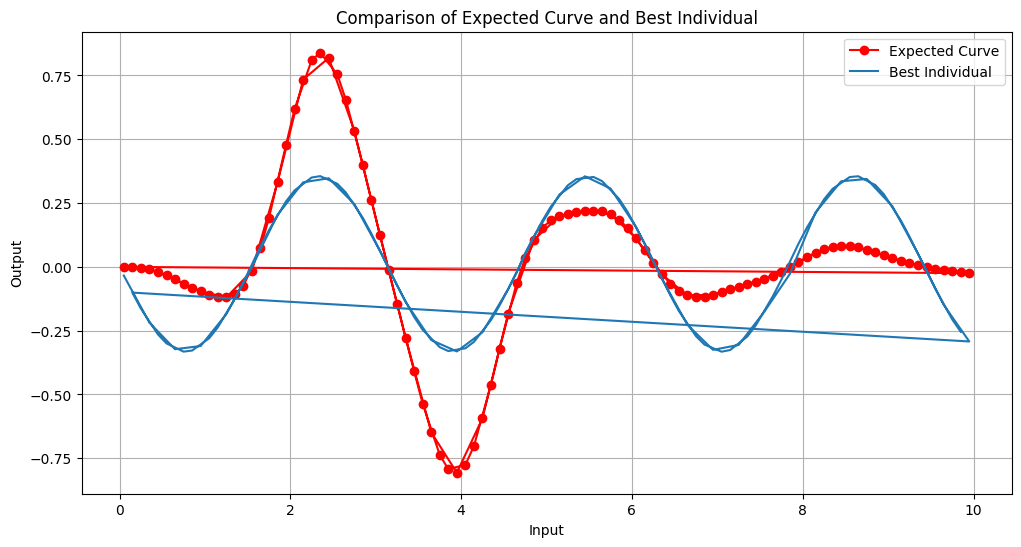

In [326]:
# Compile the best individual to a Python function
f = gp.compile(expr=best_individual, pset=pset)

# Generate outputs using the best individual
output = [f(x) for x, _ in points]
inputs = [x for x, _ in points]
expected_out = [y for _, y in points]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(inputs, expected_out, 'o-', color="red", label='Expected Curve')
plt.plot(inputs, output, label='Best Individual')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Comparison of Expected Curve and Best Individual')
plt.legend()
plt.grid(True)
plt.show()